C:\Users\kk980\AppData\Local\Temp\ipykernel_74508\4201702424.py:100: MatrixRankWarning: Matrix is exactly singular
  x_f = spla.spsolve(K_ff, F_f)


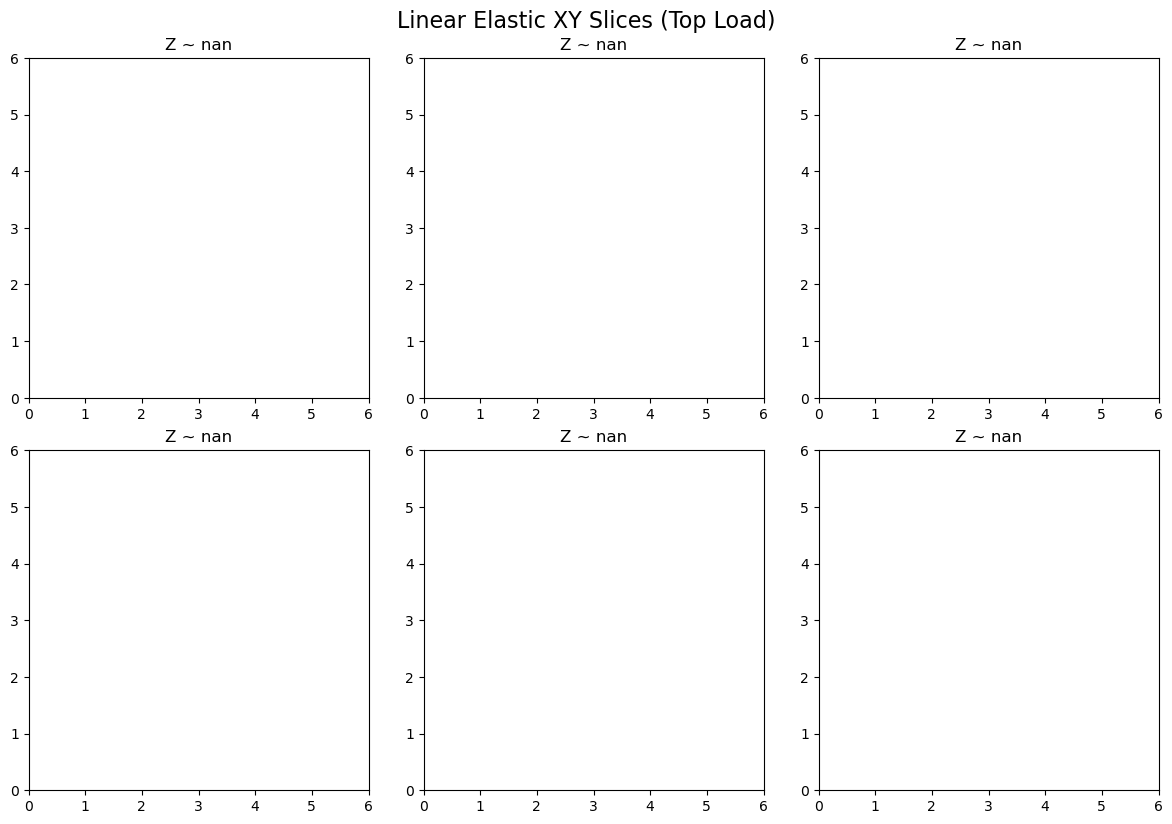

In [5]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt

# 격자 크기 설정
nx, ny, nz = 6, 6, 6
spacing = 1.0
k = 10.0  # 스프링 상수

# 노드 위치 정의
nodes = []
for z in range(nz):
    for y in range(ny):
        for x in range(nx):
            nodes.append([x * spacing, y * spacing, z * spacing])
nodes = np.array(nodes)
N = len(nodes)

# 스프링 연결 (x, y, z 방향만)
edges = []
node_dict = {(x, y, z): i for i, (x, y, z) in enumerate(nodes / spacing)}
for z in range(nz):
    for y in range(ny):
        for x in range(nx):
            i = node_dict[(x, y, z)]
            for dx, dy, dz in [(1,0,0),(0,1,0),(0,0,1)]:
                nx_, ny_, nz_ = x+dx, y+dy, z+dz
                if (nx_, ny_, nz_) in node_dict:
                    j = node_dict[(nx_, ny_, nz_)]
                    edges.append((i, j))

# 스프링 방향 벡터, 초기 길이
rest_lengths = []
directions = []
for i, j in edges:
    vec = nodes[j] - nodes[i]
    L0 = np.linalg.norm(vec)
    rest_lengths.append(L0)
    directions.append(vec / L0)

# 전체 강성 행렬 구성 (3N x 3N)
row = []
col = []
data = []

def add_spring(i, j, k, direction, L0):
    """Adds stiffness matrix contributions for a spring between i and j."""
    d = direction.reshape(3, 1)
    K_local = k * (d @ d.T) / L0  # 3x3 matrix

    for a in range(3):
        for b in range(3):
            # i-i
            row.append(3*i + a)
            col.append(3*i + b)
            data.append(K_local[a, b])
            # j-j
            row.append(3*j + a)
            col.append(3*j + b)
            data.append(K_local[a, b])
            # i-j
            row.append(3*i + a)
            col.append(3*j + b)
            data.append(-K_local[a, b])
            # j-i
            row.append(3*j + a)
            col.append(3*i + b)
            data.append(-K_local[a, b])

for (idx, (i, j)) in enumerate(edges):
    add_spring(i, j, k, directions[idx], rest_lengths[idx])

K = sp.coo_matrix((data, (row, col)), shape=(3*N, 3*N)).tocsc()

# 외력 벡터 F (국소 압력 상단 중앙)
F = np.zeros(3*N)
top_z = np.max(nodes[:, 2])
center_x = np.mean(nodes[:, 0])
center_y = np.mean(nodes[:, 1])
pressure_radius = spacing * 1.5

for i, n in enumerate(nodes):
    if abs(n[2] - top_z) < 1e-3 and np.linalg.norm(n[:2] - [center_x, center_y]) < pressure_radius:
        F[3*i + 2] = -1.0  # z 방향 하중

# 고정된 노드 인덱스 (z==0)
fixed = [i for i, n in enumerate(nodes) if n[2] == 0]
fixed_dofs = []
for i in fixed:
    fixed_dofs += [3*i + 0, 3*i + 1, 3*i + 2]

# 자유도 분리
all_dofs = np.arange(3*N)
free_dofs = np.setdiff1d(all_dofs, fixed_dofs)

# 시스템 해석: K_ff * x_f = F_f
K_ff = K[free_dofs, :][:, free_dofs]
F_f = F[free_dofs]
x_f = spla.spsolve(K_ff, F_f)

# 전체 변위 벡터 구성
x = np.zeros(3*N)
x[free_dofs] = x_f
u = x.reshape((-1, 3))  # 변위 벡터

# 변형된 위치
x_final = nodes + u

# 중간 Z slice 시각화
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()
z_vals = np.linspace(np.min(x_final[:,2]), np.max(x_final[:,2]), 6)

for idx, z_val in enumerate(z_vals):
    ax = axes[idx]
    indices = [i for i, n in enumerate(x_final) if abs(n[2] - z_val) < 0.5]
    points = x_final[indices]
    ax.scatter(points[:, 0], points[:, 1], c='b')
    ax.set_title(f"Z ~ {z_val:.2f}")
    ax.set_xlim(0, nx)
    ax.set_ylim(0, ny)
    ax.set_aspect('equal')

plt.tight_layout()
plt.suptitle("Linear Elastic XY Slices (Top Load)", fontsize=16, y=1.02)
plt.show()


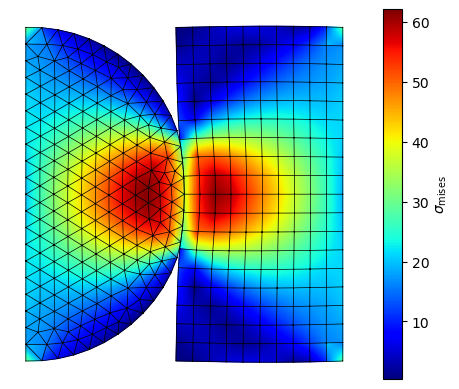

In [17]:
r"""Contact problem.

Mortar methods allow setting interface conditions on non-matching meshes.
They are useful also when solving variational inequalities such as
`elastic contact problems <https://arxiv.org/abs/1902.09312>`_.

"""

import numpy as np
from skfem import *
from skfem.supermeshing import intersect, elementwise_quadrature
from skfem.models.elasticity import (linear_elasticity, lame_parameters,
                                     linear_stress)
from skfem.helpers import dot, sym_grad, jump, mul
from skfem.io.json import from_file
from pathlib import Path


# create meshes
mesh_file = 'ex04_mesh.json'
m1 = from_file(mesh_file)
m2 = (
    (MeshLine(np.linspace(1, 2, 6)) * MeshLine(np.linspace(-1, 1, 10)))
    .refined()
    .with_boundaries({
        'contact': lambda x: x[0] == 1.0,
        'dirichlet': lambda x: x[0] == 2.0,
    })
)

e1 = ElementVector(ElementTriP2())
e2 = ElementVector(ElementQuad2())

# create trace meshes and project
m1t, orig1 = m1.trace('contact', mtype=MeshLine, project=lambda p: p[1:])
m2t, orig2 = m2.trace('contact', mtype=MeshLine, project=lambda p: p[1:])

# create a supermesh for integration
m12, t1, t2 = intersect(m1t, m2t)

basis1 = Basis(m1, e1)
basis2 = Basis(m2, e2)

fbasis1 = FacetBasis(m1, e1,
                     quadrature=elementwise_quadrature(m1t, m12, t1),
                     facets=orig1[t1])
fbasis2 = FacetBasis(m2, e2,
                     quadrature=elementwise_quadrature(m2t, m12, t2),
                     facets=orig2[t2])
fbasis = fbasis1 * fbasis2

# problem definition
youngs_modulus = 1000.0
poisson_ratio = 0.3

weakform = linear_elasticity(*lame_parameters(youngs_modulus, poisson_ratio))
C = linear_stress(*lame_parameters(youngs_modulus, poisson_ratio))

alpha = 1000
limit = 0.3

# mortar forms
@BilinearForm
def bilin_mortar(u1, u2, v1, v2, w):
    ju = dot(u1 - u2, w.n)
    jv = dot(v1 - v2, w.n)
    mu = .5 * (dot(w.n, mul(C(sym_grad(u1)), w.n))
               + dot(w.n, mul(C(sym_grad(u2)), w.n)))
    mv = .5 * (dot(w.n, mul(C(sym_grad(v1)), w.n))
               + dot(w.n, mul(C(sym_grad(v2)), w.n)))
    return ((1. / (alpha * w.h) * ju * jv - mu * jv - mv * ju)
            * (np.abs(w.x[1]) <= limit))

def gap(x):
    return (1. - np.sqrt(1. - x[1] ** 2))

@LinearForm
def lin_mortar(v1, v2, w):
    jv = dot(v1 - v2, w.n)
    mv = .5 * (dot(w.n, mul(C(sym_grad(v1)), w.n))
               + dot(w.n, mul(C(sym_grad(v2)), w.n)))
    return ((1. / (alpha * w.h) * gap(w.x) * jv - gap(w.x) * mv)
            * (np.abs(w.x[1]) <= limit))

# fix mesh parameter and normals from m2
params = {
    'h': fbasis2.mesh_parameters(),
    'n': -fbasis2.normals,
}

# assemble the block system
A1 = asm(weakform, basis1)
A2 = asm(weakform, basis2)
B = asm(bilin_mortar, fbasis, **params)
f = asm(lin_mortar, fbasis, **params)

K = bmat([[A1, None],
          [None, A2]], 'csr') + B

D1 = basis1.get_dofs('dirichlet').all()
D2 = basis2.get_dofs('dirichlet').all() + basis1.N

# initialize boundary conditions
y1 = basis1.zeros()
y2 = basis2.zeros()
y1[basis1.get_dofs('dirichlet').all('u^1')] = .1
y = np.concatenate((y1, y2))

# linear solve
y = solve(*condense(K, f, D=np.concatenate((D1, D2)), x=y))

# create a displaced mesh for visualization
sf = 1
(y1, _), (y2, _) = fbasis.split(y)
mdefo1 = m1.translated(sf * y1[basis1.nodal_dofs])
mdefo2 = m2.translated(sf * y2[basis2.nodal_dofs])

# calculate von Mises stress
s1, s2 = {}, {}
dg1 = basis1.with_element(ElementTriDG(ElementTriP1()))
dg2 = basis2.with_element(ElementQuadDG(ElementQuad1()))
u1 = basis1.interpolate(y1)
u2 = basis2.interpolate(y2)

for i in [0, 1]:
    for j in [0, 1]:
        s1[i, j] = dg1.project(C(sym_grad(u1))[i, j])
        s2[i, j] = dg2.project(C(sym_grad(u2))[i, j])

s1[2, 2] = poisson_ratio * (s1[0, 0] + s1[1, 1])
s2[2, 2] = poisson_ratio * (s2[0, 0] + s2[1, 1])

vonmises1 = np.sqrt(.5 * ((s1[0, 0] - s1[1, 1]) ** 2 +
                          (s1[1, 1] - s1[2, 2]) ** 2 +
                          (s1[2, 2] - s1[0, 0]) ** 2 +
                          6. * s1[0, 1] ** 2))

vonmises2 = np.sqrt(.5 * ((s2[0, 0] - s2[1, 1]) ** 2 +
                          (s2[1, 1] - s2[2, 2]) ** 2 +
                          (s2[2, 2] - s2[0, 0]) ** 2 +
                          6. * s2[0, 1] ** 2))


def visualize():
    from skfem.visuals.matplotlib import plot, draw
    pdg1 = Basis(mdefo1, dg1.elem)
    pdg2 = Basis(mdefo2, dg2.elem)
    ax = plot(pdg1,
              vonmises1,
              shading='gouraud',
              colorbar=r"$\sigma_{\mathrm{mises}}$")
    draw(mdefo1, ax=ax)
    plot(pdg2, vonmises2, ax=ax, nrefs=3, shading='gouraud')
    draw(mdefo2, ax=ax)
    return ax



visualize().show()